## importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading train data

In [2]:
df = pd.read_csv("analytics_assignment_data.csv")
df.head()


,date,num_orders,order_status,total_cbv,service
0,2016-01-01,180,Cancelled,76076000,GO-BOX
1,2016-01-01,10,Cancelled,1960140,GO-CLEAN
2,2016-01-01,28380,Cancelled,489898500,GO-FOOD
3,2016-01-01,0,Cancelled,728000,GO-GLAM
4,2016-01-01,10,Cancelled,136500,GO-KILAT


In [3]:
df['order_status'].unique()

array(['Cancelled', 'Completed', 'Failed/Timeout', 'No Driver Found',
       'Other'], dtype=object)

## Pre_processing steps

Pre-processing (do it in this order):
1. Remove GO-TIX
2. Keep only `Cancelled` order_status
3. Ensure the complete combinations (cartesian product) of date and service are present
4. Impute missing values with 0
5. Create is_weekend flag predictor (1 if Saturday/Sunday, 0 if other days)
6. One-hot encode month and day of week predictors
7. Standardise predictors (mean = 0, standard deviation = 1) using train-period data only

In [4]:
# remove GO-TIX and keep only "Cancelled status"
df = df[df.service !="GO-TIX"]
df = df[df.order_status == 'Cancelled']

##### Ensure the complete combinations (cartesian product) of date and service are present

In [5]:
# checking shape of remaining data
df.head()

,date,num_orders,order_status,total_cbv,service
0,2016-01-01,180,Cancelled,76076000,GO-BOX
1,2016-01-01,10,Cancelled,1960140,GO-CLEAN
2,2016-01-01,28380,Cancelled,489898500,GO-FOOD
3,2016-01-01,0,Cancelled,728000,GO-GLAM
4,2016-01-01,10,Cancelled,136500,GO-KILAT


In [6]:
df1 = pd.DataFrame()
date_array = df.date.unique()
service_array = df.service.unique()

In [7]:
x = np.transpose([np.tile(date_array, len(service_array)), np.repeat(service_array, len(date_array))])
df1 = pd.DataFrame(x,columns = ['date' , 'service'])
print(df1.shape)
result = pd.merge(df, df1,how='right',on=['date', 'service'])

(920, 2)


In [8]:
result.head()

,date,num_orders,order_status,total_cbv,service
0,2016-01-01,180.0,Cancelled,76076000.0,GO-BOX
1,2016-01-01,10.0,Cancelled,1960140.0,GO-CLEAN
2,2016-01-01,28380.0,Cancelled,489898500.0,GO-FOOD
3,2016-01-01,0.0,Cancelled,728000.0,GO-GLAM
4,2016-01-01,10.0,Cancelled,136500.0,GO-KILAT


##### Impute missing values with 0

In [9]:
# fill na with 0 and cancelled
result['num_orders'] = result.num_orders.fillna(0)
result[' total_cbv '] = result[' total_cbv '].fillna(0)
result['order_status'] = result.order_status.fillna('Cancelled')

In [10]:
# converting float value into integer
result[' total_cbv '] = result[' total_cbv '].apply(lambda x : int(x))
result['num_orders'] = result['num_orders'].apply(lambda x : int(x))

In [11]:
result[result['num_orders']==0].shape

(40, 5)

##### Create is_weekend flag predictor (1 if Saturday/Sunday, 0 if other days)

In [12]:
def find_month(date):
    months = ['' , 'January' , 'Februray' , 'March' ,'April' , 'May', 'June' , 'July' , 'August' , 'Spetember', 'October' , 'November' , 'Decemver']
    datetime_format = datetime.datetime.strptime(date, '%Y-%m-%d')
    month_name =  datetime_format.month
    return months[month_name]

def find_day(date):
    datetime_format = datetime.datetime.strptime(date, '%Y-%m-%d')
    return datetime_format.day

def get_weekday(date):
    week_days= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
    #date  = '2016-04-01'
    datetime_format = datetime.datetime.strptime(date, '%Y-%m-%d')
    day= datetime_format.weekday()
    return ((week_days[day]))

def get_weekday_flag(week_day):
    if week_day == 'Saturday' or week_day == 'Sunday':
        return 1
    else:
        return 0

In [13]:
result["month"] = result.date.apply(lambda x : find_month(x))
result['day'] = result.date.apply(lambda x : find_day(x))
result['week_day'] = result.date.apply(lambda x : get_weekday(x))

In [14]:
result['week_day_flag'] = result.week_day.apply(get_weekday_flag)

In [15]:
result = result.sort_values(by = 'date')

In [16]:
train = result[0:889]
forecast = result[890:]

In [17]:
train['date'] = pd.to_datetime(train['date'])
forecast['date'] = pd.to_datetime(forecast['date'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
train_services  = train['service'].to_list()
forecast_services  = forecast['service'].to_list()
#len(services)

In [19]:
# train = train.set_index('date')
# forecast = forecast.set_index('date')

In [20]:
X_one_hot = train.drop(['order_status' , 'service' , 'num_orders' ],1)
forecast_t = forecast.drop(['order_status' , 'service' , 'num_orders'],1)

In [21]:
X_one_hot = pd.get_dummies(X_one_hot)
forecast_t = pd.get_dummies(forecast_t)

In [22]:
forecast_t.keys()

Index(['date', ' total_cbv ', 'day', 'week_day_flag', 'month_April',
       'month_March', 'week_day_Friday', 'week_day_Thursday',
       'week_day_Wednesday'],
      dtype='object')

#### question1 :After all the pre-processing steps, what is the value of all the predictors for service = GO-FOOD,date = 2016-02-28?

In [23]:
X_one_hot_scaler = X_one_hot.copy()

In [24]:
X_one_hot_scaler.dtypes

date                  datetime64[ns]
 total_cbv                     int64
day                            int64
week_day_flag                  int64
month_Februray                 uint8
month_January                  uint8
month_March                    uint8
week_day_Friday                uint8
week_day_Monday                uint8
week_day_Saturday              uint8
week_day_Sunday                uint8
week_day_Thursday              uint8
week_day_Tuesday               uint8
week_day_Wednesday             uint8
dtype: object

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # create an instance
X_train_num_orders  = train['num_orders']
X_orders_array = np.reshape(X_train_num_orders.values,(889,1))
X_train_std_orders = scaler.fit_transform(X_orders_array)
X_one_hot_scaler['standard_num_orders'] = X_train_std_orders
# X_one_hot_scaler[['date', ' total_cbv ', 'day', 'week_day_flag', 'month_Februray',
#        'month_January', 'month_March', 'week_day_Friday', 'week_day_Monday',
#        'week_day_Saturday', 'week_day_Sunday', 'week_day_Thursday',
#        'week_day_Tuesday', 'week_day_Wednesday']] = scaler.fit_transform(X_one_hot_scaler)

In [26]:
X_one_hot_scaler.keys()

Index(['date', ' total_cbv ', 'day', 'week_day_flag', 'month_Februray',
       'month_January', 'month_March', 'week_day_Friday', 'week_day_Monday',
       'week_day_Saturday', 'week_day_Sunday', 'week_day_Thursday',
       'week_day_Tuesday', 'week_day_Wednesday', 'standard_num_orders'],
      dtype='object')

In [27]:
X_one_hot_scaler['service'] = train_services

In [28]:
data = X_one_hot_scaler[(X_one_hot_scaler['service'] == 'GO-FOOD') & (X_one_hot_scaler['date'] == '2016-02-28')]

In [29]:
data

,date,total_cbv,day,week_day_flag,month_Februray,month_January,month_March,week_day_Friday,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday,standard_num_orders,service
572,2016-02-28,267558200,28,1,1,0,0,0,0,0,1,0,0,0,0.332317,GO-FOOD


#### Question 2 : Show the first 6 rows of one-hot encoded variables (month and day of the week)

In [30]:
X_one_hot_scaler.head(6)

,date,total_cbv,day,week_day_flag,month_Februray,month_January,month_March,week_day_Friday,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday,standard_num_orders,service
0,2016-01-01,76076000,1,0,0,1,0,1,0,0,0,0,0,0,-0.484005,GO-BOX
1,2016-01-01,1960140,1,0,0,1,0,1,0,0,0,0,0,0,-0.492788,GO-CLEAN
2,2016-01-01,489898500,1,0,0,1,0,1,0,0,0,0,0,0,0.972975,GO-FOOD
3,2016-01-01,728000,1,0,0,1,0,1,0,0,0,0,0,0,-0.493305,GO-GLAM
4,2016-01-01,136500,1,0,0,1,0,1,0,0,0,0,0,0,-0.492788,GO-KILAT
5,2016-01-01,23933000,1,0,0,1,0,1,0,0,0,0,0,0,-0.404956,GO-MART


#### Question 3 : Print the first 6 rows of the data after pre-processing for service = GO-KILAT. Sort ascendingly

In [31]:
X_one_hot_scaler[X_one_hot_scaler.service == 'GO-KILAT'].sort_values(by = 'date').head(6)

,date,total_cbv,day,week_day_flag,month_Februray,month_January,month_March,week_day_Friday,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday,standard_num_orders,service
4,2016-01-01,136500,1,0,0,1,0,1,0,0,0,0,0,0,-0.492788,GO-KILAT
910,2016-01-02,0,2,1,0,1,0,0,0,1,0,0,0,0,-0.493305,GO-KILAT
911,2016-01-03,0,3,1,0,1,0,0,0,0,1,0,0,0,-0.493305,GO-KILAT
32,2016-01-04,54600,4,0,0,1,0,0,1,0,0,0,0,0,-0.493305,GO-KILAT
42,2016-01-05,81900,5,0,0,1,0,0,0,0,0,0,1,0,-0.493305,GO-KILAT
52,2016-01-06,27300,6,0,0,1,0,0,0,0,0,0,0,1,-0.493305,GO-KILAT


In [32]:
#list_of_services = X_one_hot['service'].to_list()

In [33]:
X_train = X_one_hot_scaler.sort_values(by='date').reset_index()

In [34]:
X_train = X_train.set_index('date')
forecast_t = forecast_t.set_index('date')


In [35]:
forecast_t.keys()

Index([' total_cbv ', 'day', 'week_day_flag', 'month_April', 'month_March',
       'week_day_Friday', 'week_day_Thursday', 'week_day_Wednesday'],
      dtype='object')

In [36]:
forecast_t['service'] = forecast_services

#### MAPE formula

In [37]:
services = X_train.service.unique()
services

array(['GO-BOX', 'GO-CLEAN', 'GO-FOOD', 'GO-GLAM', 'GO-KILAT', 'GO-MART',
       'GO-MASSAGE', 'GO-RIDE', 'GO-SEND', 'GO-SHOP'], dtype=object)

In [38]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return mape

In [39]:
X_train.keys()

Index(['index', ' total_cbv ', 'day', 'week_day_flag', 'month_Februray',
       'month_January', 'month_March', 'week_day_Friday', 'week_day_Monday',
       'week_day_Saturday', 'week_day_Sunday', 'week_day_Thursday',
       'week_day_Tuesday', 'week_day_Wednesday', 'standard_num_orders',
       'service'],
      dtype='object')

In [40]:
forecast_list = []

### GO_BOX GRAPH

In [41]:
from statsmodels.tsa.arima_model import ARIMA

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

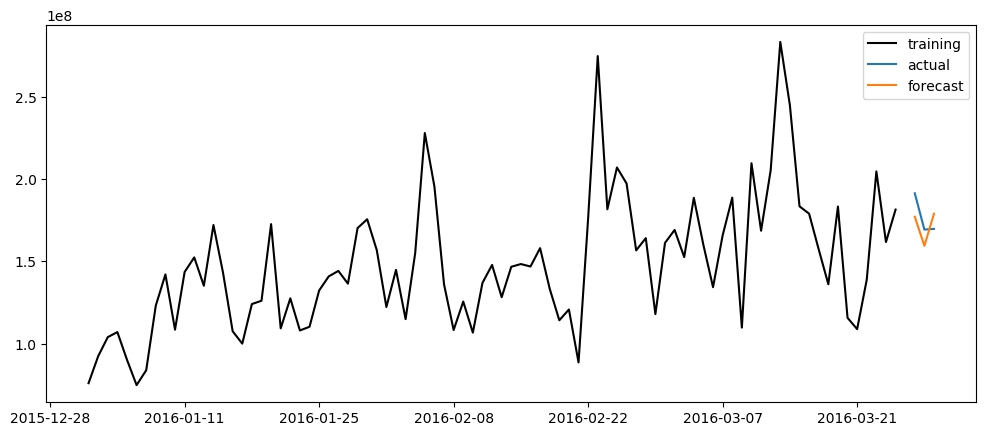

In [65]:
X_train_data = X_train[X_train.service == 'GO-BOX']
forecast_data = forecast_t[forecast_t.service == 'GO-BOX']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(4,1,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()
#     print(forecast)
#     return forecast
    #forecast_list.append(forecast)

In [43]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-CLEAN

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

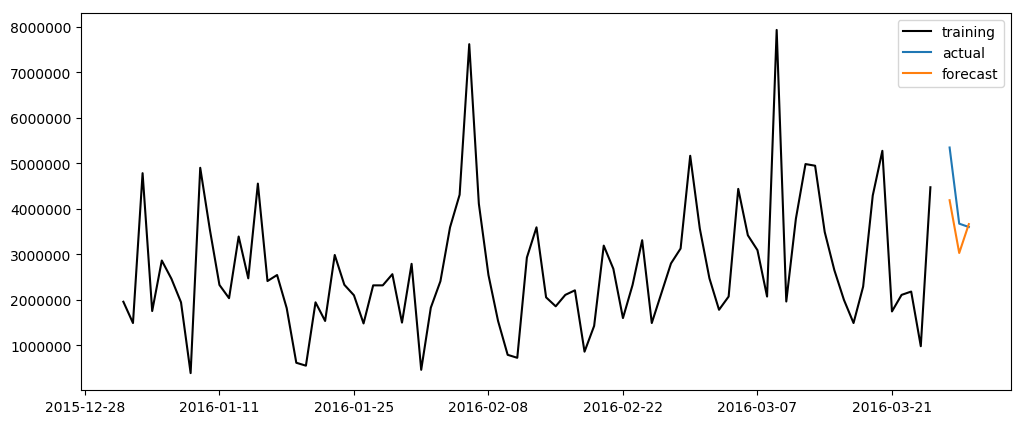

In [66]:
X_train_data = X_train[X_train.service == 'GO-CLEAN']
forecast_data = forecast_t[forecast_t.service == 'GO-CLEAN']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(5,2,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [45]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-FOOD

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

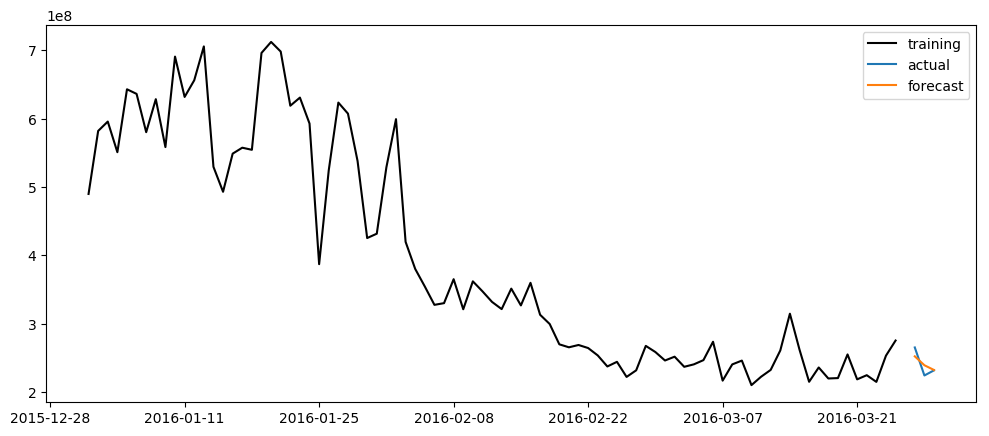

In [67]:
X_train_data = X_train[X_train.service == 'GO-FOOD']
forecast_data = forecast_t[forecast_t.service == 'GO-FOOD']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=False, solver='ncg')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [47]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-GLAM

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

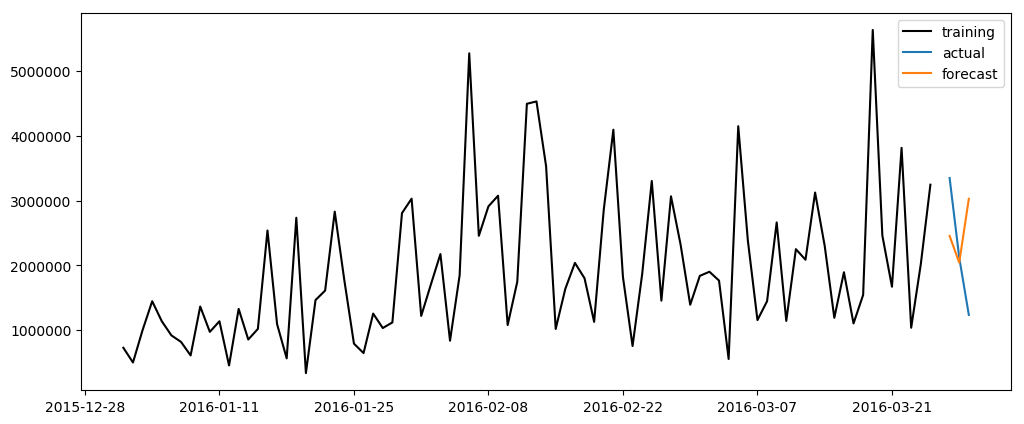

In [68]:
X_train_data = X_train[X_train.service == 'GO-GLAM']
forecast_data = forecast_t[forecast_t.service == 'GO-GLAM']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [49]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-KILAT

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


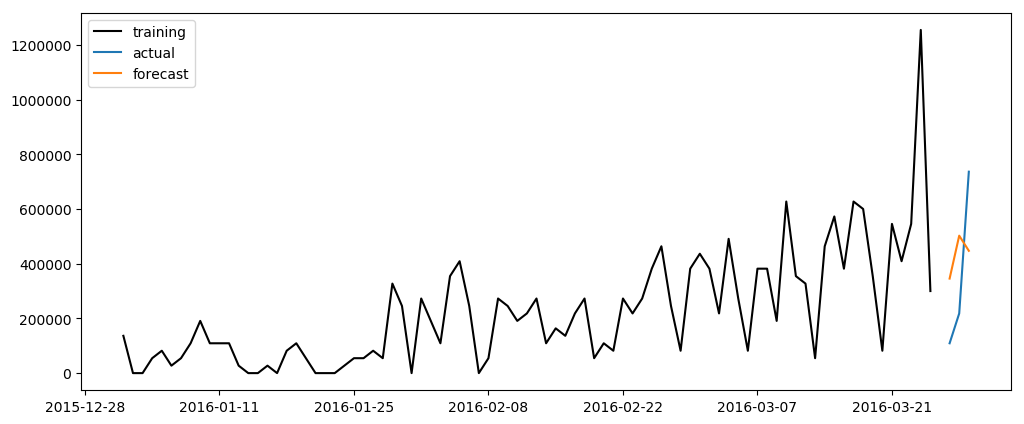

In [69]:
X_train_data = X_train[X_train.service == 'GO-KILAT']
forecast_data = forecast_t[forecast_t.service == 'GO-KILAT']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
#model = ExponentialSmoothing(train,seasonal_periods=7 ,trend='add', seasonal='add',)
model = ARIMA(train, order=(6,2,1))
#fit1.forecast(len(valid))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [51]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
#forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO_MART

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

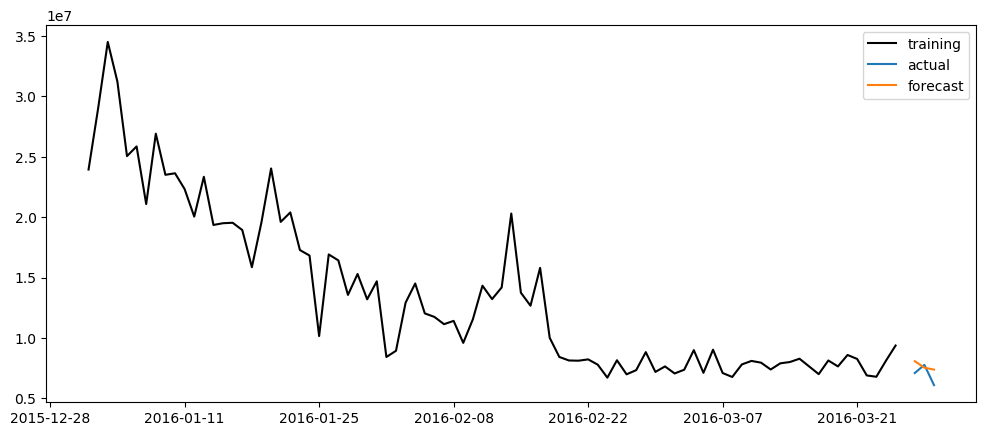

In [70]:
X_train_data = X_train[X_train.service == 'GO-MART']
forecast_data = forecast_t[forecast_t.service == 'GO-MART']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(4,1,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [53]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-MASSAGE

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

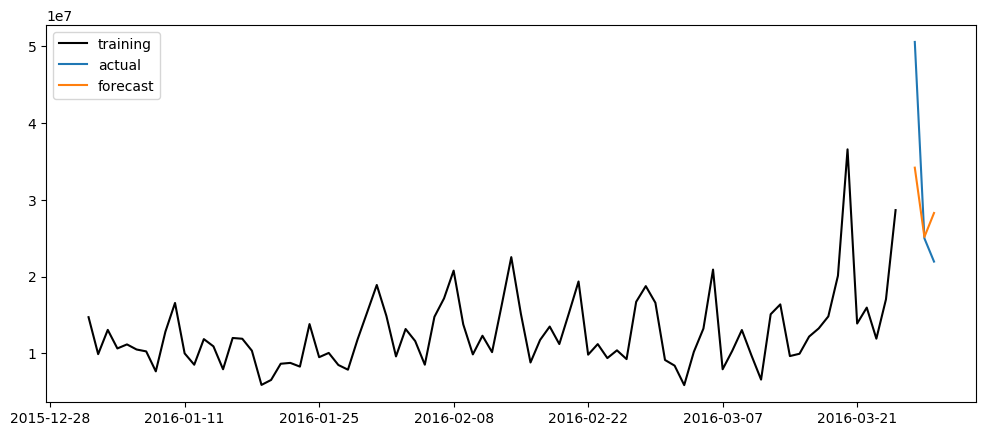

In [71]:
X_train_data = X_train[X_train.service == 'GO-MASSAGE']
forecast_data = forecast_t[forecast_t.service == 'GO-MASSAGE']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(5,2,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [55]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-RIDE

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

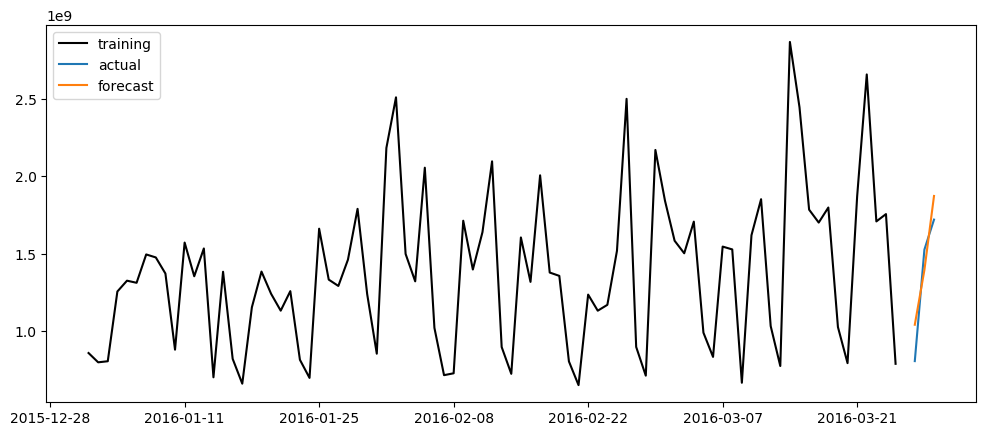

In [72]:
X_train_data = X_train[X_train.service == 'GO-RIDE']
forecast_data = forecast_t[forecast_t.service == 'GO-RIDE']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [57]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-SEND

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

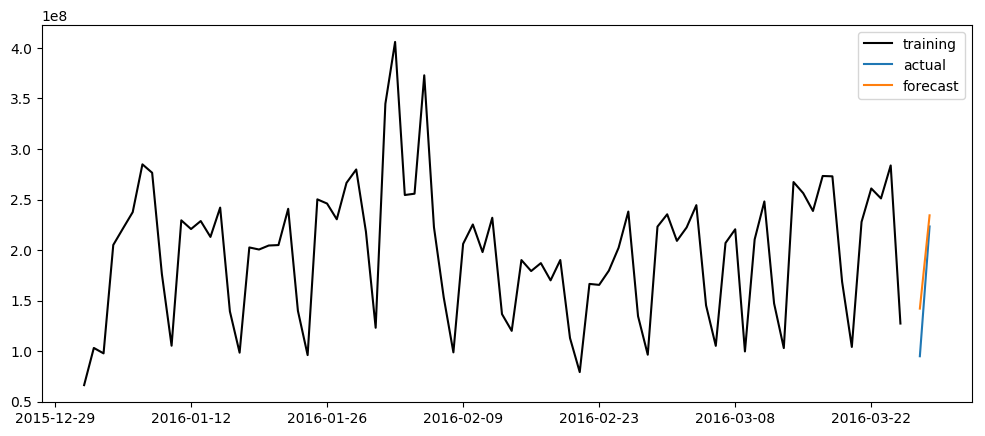

In [73]:
X_train_data = X_train[X_train.service == 'GO-SEND']
forecast_data = forecast_t[forecast_t.service == 'GO-SEND']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(4,1,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [59]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

### GO-SHOP

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

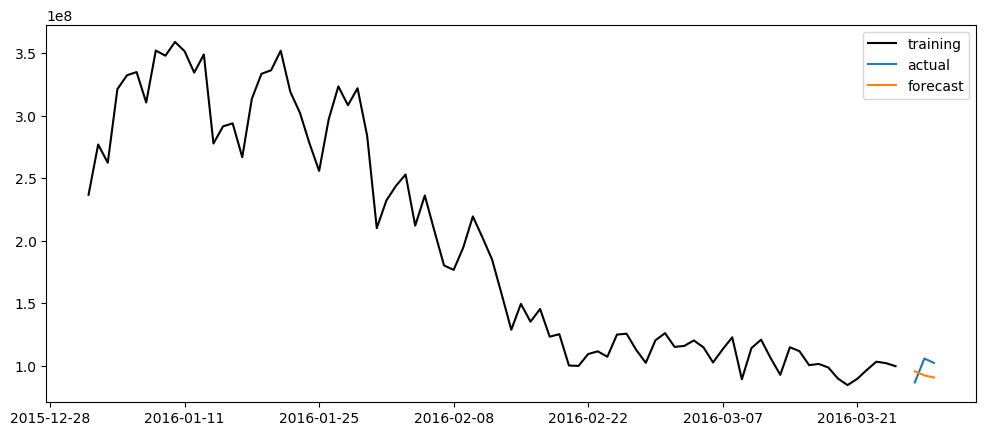

In [81]:
X_train_data = X_train[X_train.service == 'GO-SHOP']
forecast_data = forecast_t[forecast_t.service == 'GO-SHOP']
X_train_data = X_train_data[[' total_cbv ']]
forecast_data = forecast_data[[' total_cbv ']]
train = X_train_data[0:85]
valid = X_train_data[86:]
model = ARIMA(train, order=(4,1,0))
model_fit = model.fit(disp=False, solver='powell')
fc_valid, se, conf = model_fit.forecast(len(valid))
fc_series = pd.Series(fc_valid, index=valid.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[' total_cbv '], label='training' , color = 'black')
plt.plot(valid[' total_cbv '], label='actual')
plt.plot(fc_series, label='forecast')
plt.legend(loc='best')
plt.show()

In [61]:
fc, se, conf = model_fit.forecast(len(forecast_data))
pred = [int(i) for i in fc]
forecast = forecast_accuracy(pred , forecast_data[' total_cbv '])
forecast_list.append(forecast)

In [62]:
question_4_df  = pd.DataFrame()
question_4_df['service'] = services

In [63]:
question_4_df['MAPE_forecast_period'] =  forecast_list

#### question 4

In [64]:
question_4_df.sort_values(by='MAPE_forecast_period')

,service,MAPE_forecast_period
0,GO-BOX,0.055736
2,GO-FOOD,0.080123
5,GO-MART,0.097900
3,GO-GLAM,0.128319
9,GO-SHOP,0.136190
7,GO-RIDE,0.162492
1,GO-CLEAN,0.269746
4,GO-KILAT,0.290046
8,GO-SEND,0.302721
6,GO-MASSAGE,0.307214
